In [1]:
import numpy as np
import os
import warnings
import pandas as pd
import scipy.interpolate as scintrp
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy.signal import savgol_filter as smooth

import foam
import windPlotters as wPlt
import wind

In [2]:
dir_wtVl_tngE2 = r"D:/tempData_depot/simData_CandC/wt_tngE2/"
inflowDir_E2 = dir_wtVl_tngE2+r"inflow/"

lScl=0.02
H = 0.08

# Load the target wind field

In [3]:
dt_cobraProbe = 6.2500e-04

temp = pd.read_csv(dir_wtVl_tngE2+"profiles.csv")
U_TH = np.load(dir_wtVl_tngE2+"UofT.npy")
V_TH = np.load(dir_wtVl_tngE2+"VofT.npy")
W_TH = np.load(dir_wtVl_tngE2+"WofT.npy")
wtVel_E2 = wind.profile(name="BLWT-E2", Z=temp.Z,UofT=U_TH,VofT=V_TH,WofT=W_TH,H=H,dt=dt_cobraProbe,nSpectAvg=16)

# U_TH = V_TH = W_TH = None

esdu74_E2 = wind.ESDU74(z0=0.01, Zref=H/lScl, Uref=25.0, Z=np.logspace(-1,2,100))
esdu85_E2 = wind.ESDU74(z0=0.01, Zref=H/lScl, Uref=25.0, Z=np.logspace(-1,2,100))


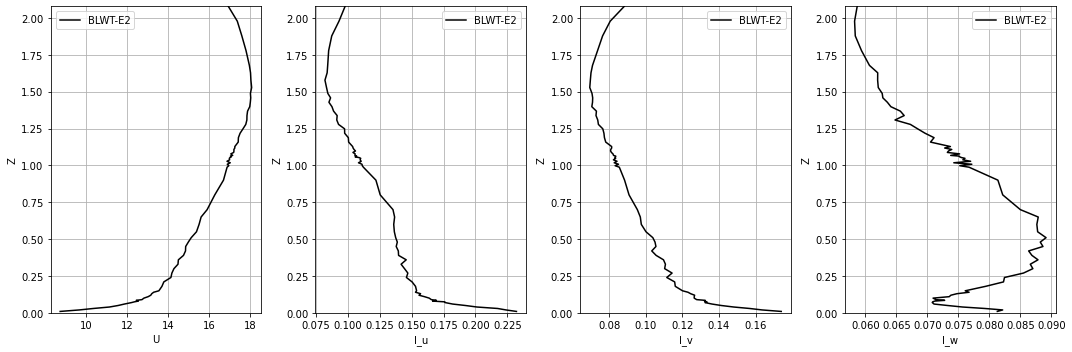

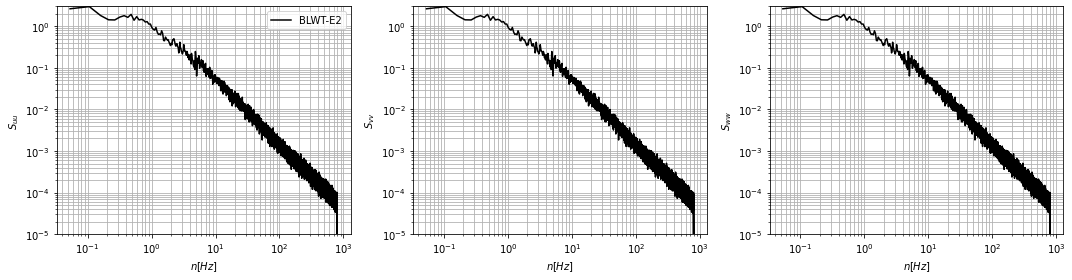

In [4]:
wtVel_E2.plotProfiles(figSize=[15,5])

ylim = [1e-5,3e0]
wtVel_E2.SpectH.plotSpectra(figSize=[15,4],normalize=False,yLimits=(ylim,ylim,ylim))

# Extract smoothed data

In [5]:
def exp_mov_avg(x, alpha):
    y = np.zeros_like(x)
    y[0] = x[0]
    for i in range(1, len(x)):
        y[i] = alpha * x[i] + (1 - alpha) * y[i-1]
    return y

def mov_avg(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def smooth(data, window_length, polyorder):
    from scipy.signal import savgol_filter
    smoothed_data = savgol_filter(data, window_length=window_length, polyorder=polyorder)
    return smoothed_data


In [6]:
sIdx = 0
eIdx = np.argmin(np.abs(wtVel_E2.Z - 1.5))+1
s = 19

Z = np.array(wtVel_E2.Z[sIdx:eIdx])
U = smooth(wtVel_E2.U, 9, 3)[sIdx:eIdx]
Iu = smooth(wtVel_E2.Iu, 9, 3)[sIdx:eIdx]
Iv = smooth(wtVel_E2.Iv, 9, 3)[sIdx:eIdx]
Iw = smooth(wtVel_E2.Iw, 9, 3)[sIdx:eIdx]
Lu = smooth(wtVel_E2.xLu, 21, 2)[sIdx:eIdx]
Lv = smooth(wtVel_E2.xLv, 21, 2)[sIdx:eIdx]
Lw = smooth(wtVel_E2.xLw, 21, 2)[sIdx:eIdx]

prof = pd.DataFrame()
prof['Z'] = Z.tolist()
prof['U'] = U.tolist()
prof['Iu'] = Iu.tolist()
prof['Iv'] = Iv.tolist()
prof['Iw'] = Iw.tolist()
prof['Lu'] = Lu.tolist()
prof['Lv'] = Lv.tolist()
prof['Lw'] = Lw.tolist()

print(prof)


           Z          U        Iu        Iv        Iw        Lu        Lv  \
0   0.009906   8.723768  0.232967  0.173851  0.082013  1.089010  0.564253   
1   0.020066   9.666392  0.223707  0.164401  0.080942  1.180255  0.613750   
2   0.029972  10.437106  0.213567  0.155702  0.078912  1.266539  0.658584   
3   0.039878  11.055121  0.203167  0.147995  0.076371  1.347860  0.698755   
4   0.050038  11.539651  0.193122  0.141518  0.073770  1.424220  0.734262   
..       ...        ...       ...       ...       ...       ...       ...   
59  1.367790  17.909243  0.088940  0.072023  0.064873  1.393836  0.559448   
60  1.398016  17.938422  0.087985  0.071663  0.064340  1.352027  0.555959   
61  1.427988  17.979732  0.086746  0.071044  0.063831  1.306398  0.552121   
62  1.457960  18.016690  0.085208  0.070526  0.062943  1.281816  0.550560   
63  1.487932  18.037951  0.084357  0.070059  0.062569  1.261346  0.548825   

          Lw  
0   0.031039  
1   0.043442  
2   0.056444  
3   0.070045  


In [7]:
from scipy.signal import welch

def spect(data,fs,n=8,olFact=0.5,pad=False, window = 'hann'):
    N = len(data)
    # Define the parameters for the Welch method
    
    n_perseg = N//n  # Set nperseg to a larger value
    n_overlap = int(np.ceil(n_perseg * olFact))
    n_fft = max(n_perseg, 256)  # Ensure nfft is at least as large as nperseg

    # Compute the power spectral density using Welch's method
    freq, psd = welch(data, fs=fs, window=window, nperseg=n_perseg, noverlap=n_overlap, nfft=n_fft)
    return freq, psd


In [8]:
def spectSmooth(data, fs):
    freq_lf, psd_lf = spect(data, fs, n=2, olFact=0.1)
    freq_hf, psd_hf = spect(data, fs, n=1000, olFact=0.9)

    idx_lf = np.logspace(np.log10(1.5), np.log10(1000), 25, dtype=int)
    idx_lf[0] = 0
    idx_hf = 3
    
    psd_lf_smth = smooth(psd_lf, 301, 1)

    freq = np.concatenate([freq_lf[idx_lf], freq_hf[idx_hf:]])
    psd = np.concatenate([psd_lf_smth[idx_lf], psd_hf[idx_hf:]])
    return freq, psd, freq_lf, psd_lf, freq_hf, psd_hf

In [9]:
print(fs)

NameError: name 'fs' is not defined

In [ ]:
sIdx = 0
eIdx = np.argmin(np.abs(wtVel_E2.Z - 1.5))+1
fs = wtVel_E2.samplingFreq

Suu = Svv = Sww = np.array([])
for i in range(sIdx,eIdx):
    z = wtVel_E2.Z[i]
    
    freq, psd_u, freq_lf, psd_lf_u, freq_hf, psd_hf_u = spectSmooth(wtVel_E2.UofT[i,:], fs)
    _, psd_v, _, psd_lf_v, _, psd_hf_v = spectSmooth(wtVel_E2.VofT[i,:], fs)
    _, psd_w, _, psd_lf_w, _, psd_hf_w = spectSmooth(wtVel_E2.WofT[i,:], fs)
    if i == 0:
        Suu, Svv, Sww = psd_u, psd_v, psd_w
        Suu_lf, Svv_lf, Sww_lf = psd_lf_u, psd_lf_v, psd_lf_w
        Suu_hf, Svv_hf, Sww_hf = psd_hf_u, psd_hf_v, psd_hf_w
    else:
        Suu = np.vstack((Suu, psd_u))
        Svv = np.vstack((Svv, psd_v))
        Sww = np.vstack((Sww, psd_w))
        Suu_lf = np.vstack((Suu_lf, psd_lf_u))
        Svv_lf = np.vstack((Svv_lf, psd_lf_v))
        Sww_lf = np.vstack((Sww_lf, psd_lf_w))
        Suu_hf = np.vstack((Suu_hf, psd_hf_u))
        Svv_hf = np.vstack((Svv_hf, psd_hf_v))
        Sww_hf = np.vstack((Sww_hf, psd_hf_w))

    
    print(f"z = {z}, \tfreq: {np.shape(freq)}\t psd: {np.shape(psd_u)}\t Suu: {np.shape(Suu)}\t Svv: {np.shape(Svv)}\t Sww: {np.shape(Sww)}")

Suu = np.transpose(Suu)
Svv = np.transpose(Svv)
Sww = np.transpose(Sww)
Suu_lf = np.transpose(Suu_lf)
Svv_lf = np.transpose(Svv_lf)
Sww_lf = np.transpose(Sww_lf)
Suu_hf = np.transpose(Suu_hf)
Svv_hf = np.transpose(Svv_hf)
Sww_hf = np.transpose(Sww_hf)


In [ ]:
# import matplotlib.colors as mcolors
import matplotlib.cm as cm

def commonSettings(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(direction='in',which='both')

plt.figure(figsize=[15,10])

ax = plt.subplot(2,4,1)
plt.plot(prof.U, prof.Z, '-k.')
plt.xlabel('U')
commonSettings(ax)

ax = plt.subplot(2,4,2)
plt.plot(prof.Iu, prof.Z, '-k.')
plt.xlabel('Iu')
commonSettings(ax)

ax = plt.subplot(2,4,3)
plt.plot(prof.Iv, prof.Z, '-k.')
plt.xlabel('Iv')
commonSettings(ax)

ax = plt.subplot(2,4,4)
plt.plot(prof.Iw, prof.Z, '-k.')
plt.xlabel('Iw')
commonSettings(ax)

ax = plt.subplot(2,4,6)
plt.plot(prof.Lu, prof.Z, '-k.')
plt.xlabel('Lu')
commonSettings(ax)

ax = plt.subplot(2,4,7)
plt.plot(prof.Lv, prof.Z, '-k.')
plt.xlabel('Lv')
commonSettings(ax)

ax = plt.subplot(2,4,8)
plt.plot(prof.Lw, prof.Z, '-k.')
plt.xlabel('Lw')
commonSettings(ax)

plt.show()

plt.figure(figsize=[20,7])

N = len(prof.Z)
colors = cm.jet(np.linspace(0, 1, N))
# cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors, N=N)

# i = 0
# plt.loglog(freq_lf, Suu_lf[:,i],'-k.')
# plt.loglog(freq_hf, Suu_hf[:,i],'-r.')

ax = plt.subplot(1,3,1)
lns = []
for i in range(N):
    if i%5 == 0:
        lbl = 'Z = '+str(np.round(prof.Z[i],3)) if len(lns) == 0 else str(np.round(prof.Z[i],3))
        ln, = plt.loglog(freq, Suu[:,i],'-',color=colors[i],label=lbl)
        lns.append(ln)
    else:
        plt.loglog(freq, Suu[:,i],'-',color=colors[i],label=str(np.round(prof.Z[i],3)))
commonSettings(ax)
plt.xlabel(r'f [Hz]')
plt.ylabel(r'Suu $[m^2/s]$')
plt.legend(handles=lns)

ax = plt.subplot(1,3,2)
lns = []
for i in range(N):
    if i%5 == 0:
        lbl = 'Z = '+str(np.round(prof.Z[i],3)) if len(lns) == 0 else str(np.round(prof.Z[i],3))
        ln, = plt.loglog(freq, Svv[:,i],'-',color=colors[i],label=lbl)
        lns.append(ln)
    else:
        plt.loglog(freq, Svv[:,i],'-',color=colors[i],label=str(np.round(prof.Z[i],3)))
commonSettings(ax)
plt.xlabel('f (Hz)')
plt.ylabel('Svv')
plt.legend(handles=lns)


ax = plt.subplot(1,3,3)
lns = []
for i in range(N):
    if i%5 == 0:
        lbl = 'Z = '+str(np.round(prof.Z[i],3)) if len(lns) == 0 else str(np.round(prof.Z[i],3))
        ln, = plt.loglog(freq, Sww[:,i],'-',color=colors[i],label=lbl)
        lns.append(ln)
    else:
        plt.loglog(freq, Sww[:,i],'-',color=colors[i],label=str(np.round(prof.Z[i],3)))
commonSettings(ax)
plt.xlabel('f (Hz)')
plt.ylabel('Sww')
plt.legend(handles=lns)

plt.show()

# Write to file

In [ ]:
print(wtVel_E2.Uh)

In [ ]:
print(f"writing to: {inflowDir_E2}")
prof.to_csv(inflowDir_E2+'profile',sep=' ',index=None,header=None)

temp = pd.DataFrame(prof.Z.tolist())
temp.to_csv(inflowDir_E2+'spect_z',sep=' ',index=None,header=None)

temp = pd.DataFrame(freq.tolist())
temp.to_csv(inflowDir_E2+'spect_f',sep=' ',index=None,header=None)

temp = pd.DataFrame(Suu)
temp.to_csv(inflowDir_E2+'Suu',sep=' ',index=None,header=None)
temp = pd.DataFrame(Svv)
temp.to_csv(inflowDir_E2+'Svv',sep=' ',index=None,header=None)
temp = pd.DataFrame(Sww)
temp.to_csv(inflowDir_E2+'Sww',sep=' ',index=None,header=None)

with open(inflowDir_E2+'samplingPoints', 'a') as the_file:
    the_file.write(str(len(prof.Z))+'\n(\n')
    for z in prof.Z:
        the_file.write('(0.0 0.0 '+str(z)+')\n')
    the_file.write(');\n')

# From ESDU best fit

In [ ]:
# outdir = inflowDir_E2+'esdu/'
# es = wind.ESDU85()

# lscl = 0.01
# tscl = 0.1
# vscl = lscl/tscl

# n = np.logspace(-4.5,2,150)
# Z = es.Z
# temp = pd.DataFrame(Z)*lscl
# temp.to_csv(outdir+'spect_z',sep=' ',index=None,header=None)
# temp = pd.DataFrame(n)/tscl
# temp.to_csv(outdir+'spect_f',sep=' ',index=None,header=None)

# Nz = len(Z)
# Nf = len(n)

# Suu = Svv = Sww = np.empty((Nf,0))
# Suu_vonK = Svv_vonK = Sww_vonK = np.empty((Nf,0))

# for i, zi in enumerate(Z):
#     _, Su = es.Suu(n=n, Z=zi)
#     Suu = np.append(Suu, np.reshape(Su,(-1,1)), axis=1)
#     Su = wind.vonKarmanSuu(n=n, U=es.U(Z=zi),Iu=es.Iu(Z=zi),xLu=es.xLu(Z=zi))
#     Suu_vonK = np.append(Suu_vonK, np.reshape(Su,(-1,1)), axis=1)

#     _, Sv = es.Svv(n=n, Z=zi)
#     Svv = np.append(Svv, np.reshape(Sv,(-1,1)), axis=1)
#     Sv = wind.vonKarmanSvv(n=n, U=es.U(Z=zi),Iv=es.Iv(Z=zi),xLv=es.xLv(Z=zi))
#     Svv_vonK = np.append(Svv_vonK, np.reshape(Sv,(-1,1)), axis=1)

#     _, Sw = es.Sww(n=n, Z=zi)
#     Sww = np.append(Sww, np.reshape(Sw,(-1,1)), axis=1)
#     Sw = wind.vonKarmanSww(n=n, U=es.U(Z=zi),Iw=es.Iw(Z=zi),xLw=es.xLw(Z=zi))
#     Sww_vonK = np.append(Sww_vonK, np.reshape(Sw,(-1,1)), axis=1)


# temp = pd.DataFrame(Suu)*(lscl**2/tscl)
# temp.to_csv(outdir+'Suu',sep=' ',index=None,header=None)
# temp = pd.DataFrame(Svv)*(lscl**2/tscl)
# temp.to_csv(outdir+'Svv',sep=' ',index=None,header=None)
# temp = pd.DataFrame(Sww)*(lscl**2/tscl)
# temp.to_csv(outdir+'Sww',sep=' ',index=None,header=None)

# temp = pd.DataFrame(Suu_vonK)*(lscl**2/tscl)
# temp.to_csv(outdir+'Suu_vonK',sep=' ',index=None,header=None)
# temp = pd.DataFrame(Svv_vonK)*(lscl**2/tscl)
# temp.to_csv(outdir+'Svv_vonK',sep=' ',index=None,header=None)
# temp = pd.DataFrame(Sww_vonK)*(lscl**2/tscl)
# temp.to_csv(outdir+'Sww_vonK',sep=' ',index=None,header=None)

# temp = pd.DataFrame()
# temp['Z'] = (es.Z*lscl).tolist()
# temp['U'] = (es.U()*vscl).tolist()
# temp['Iu'] = es.Iu().tolist()
# temp['Iv'] = es.Iv().tolist()
# temp['Iw'] = es.Iw().tolist()
# temp['Lu'] = (es.xLu()*lscl).tolist()
# temp['Lv'] = (es.xLv()*lscl).tolist()
# temp['Lw'] = (es.xLw()*lscl).tolist()
# temp.to_csv(outdir+'profile',sep=' ',index=None,header=None)


# plt.figure()
# # plt.plot(es.U(), es.Z)
# plt.loglog(n ,Sww[:,50],label='ESDU')
# plt.loglog(n ,Sww_vonK[:,50],label='vonK')
# # plt.loglog(n ,Svv[:,50])
# # plt.loglog(n ,Svv)
# # plt.loglog(n ,Sww)
# # plt.xlim([0,5e-5])
# plt.legend()
# plt.show()

# Test DFSR output

In [15]:
probes, time, UofT = foam.__readProbe_singleT(inflowDir_E2+'sampledData/Ux','p')
_, _, VofT = foam.__readProbe_singleT(inflowDir_E2+'sampledData/Uy','p')
_, _, WofT = foam.__readProbe_singleT(inflowDir_E2+'sampledData/Uz','p')

UofT = np.transpose(UofT)
VofT = np.transpose(VofT)
WofT = np.transpose(WofT)

dt = time[2] - time[1]

dfsr_E2 = wind.profile(name="DFSR-E2", Z=probes[:,2], UofT=UofT, VofT=VofT, WofT=WofT, H=H, dt=dt, nSpectAvg=16)

vel_E2 = wind.Profiles([wtVel_E2, dfsr_E2])

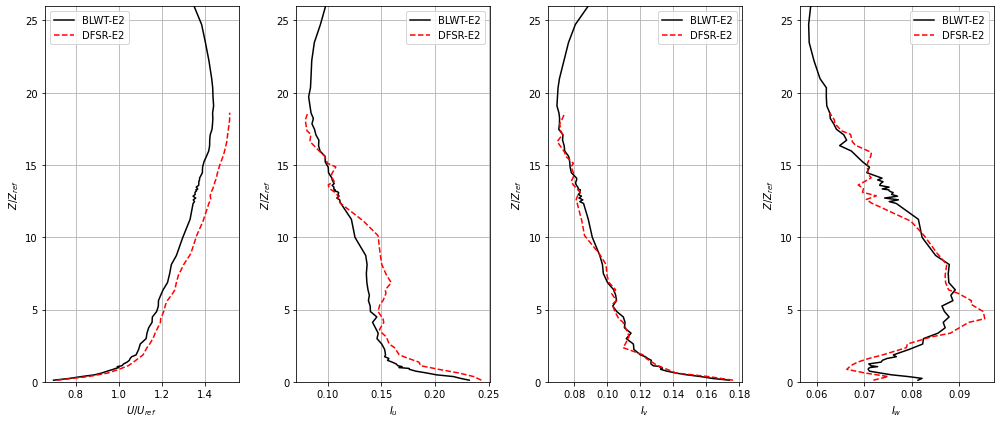

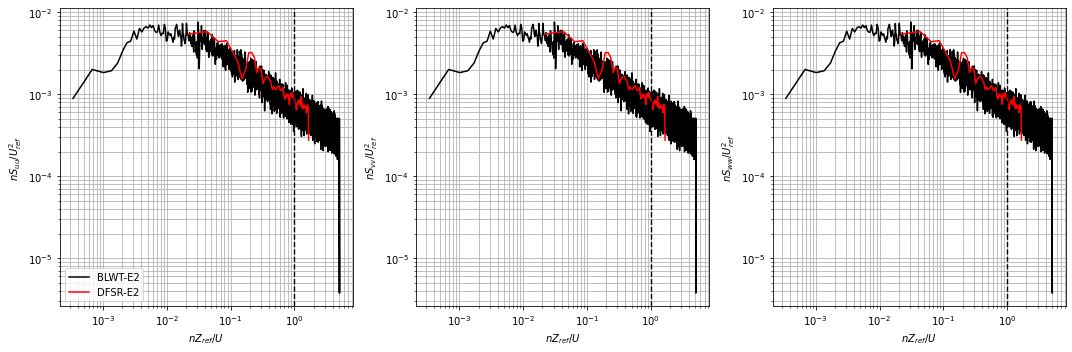

In [17]:
vel_E2.plotProfiles()
vel_E2.plotSpectra()